
# <center><u>**`Ensemble ML Algorithms - Boosting`**</u></center>




## **`TalkingData: Fraudulent Click Prediction`**






The problem statement is from 'digital fraud' sector.

The analysis is divided into the following sections:
- `Understanding the business problem`
- `Understanding and exploring the data`
- `Feature engineering: Creating new features`
- `Model building and evaluation: AdaBoost`
- `Modelling building and evaluation: Gradient Boosting`
- `Modelling building and evaluation: XGBoost`
- `Modelling building and evaluation: LightGBM`
- `Modelling building and evaluation: CatBoost`


## **`Understanding the Business Problem`**

TalkingData is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, **click fraud** is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping **approx. 70% of the active mobile devices in China**, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download). 

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud will be used.


## **`Understanding and Exploring the Data`**

The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0). 

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations).

The detailed data dictionary is mentioned here:
- ```ip```: ip address of click.
- ```app```: app id for marketing.
- ```device```: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- ```os```: os version id of user mobile phone
- ```channel```: channel id of mobile ad publisher
- ```click_time```: timestamp of click (UTC)
- ```is_attributed```: the target that is to be predicted, indicating the app was downloaded

Let's try finding some useful trends in the data.

In [1]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
#importing important libraries

import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# reading training data
df = pd.read_csv("TalkingData_train.csv")
df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,07-11-2017 09:30,0
1,105560,25,1,17,259,07-11-2017 13:40,0
2,101424,12,1,19,212,07-11-2017 18:05,0
3,94584,13,1,13,477,07-11-2017 04:58,0
4,68413,12,1,1,178,09-11-2017 09:00,0


In [4]:
# Printing length of training data
len(df)

100000

In [5]:
# Displays memory consumed by each column
print(df.memory_usage())

Index               128
ip               800000
app              800000
device           800000
os               800000
channel          800000
click_time       800000
is_attributed    800000
dtype: int64


To get space used by training data then use sum of memory consumed by each variable divided by 1024**2


In [6]:
# space used by training data
print("Training dataset uses {0}MB".format(df.memory_usage().sum()/1024**2))

Training dataset uses 5.3406982421875MB


### `Exploring the Data - Univariate Analysis`


In [7]:
# look at non-null values, null values, number of entries etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  int64 
 1   app            100000 non-null  int64 
 2   device         100000 non-null  int64 
 3   os             100000 non-null  int64 
 4   channel        100000 non-null  int64 
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 5.3+ MB


There is no missing values

## `Basic exploratory analysis `




1. Number of unique values in each column


In [8]:
# Define a function to fetch unique values in each column
def fraction_unique(x):
    # return unique values
    return len(df[x].unique())

# one line code to use above function and creating a dictionary
number_unique_vals = {x: fraction_unique(x) for x in df.columns}

#print dictionary of Unique values
number_unique_vals

{'ip': 34857,
 'app': 161,
 'device': 100,
 'os': 130,
 'channel': 161,
 'click_time': 4309,
 'is_attributed': 2}

2. Checking data type of each columns

In [9]:
# each column data type
df.dtypes

ip                int64
app               int64
device            int64
os                int64
channel           int64
click_time       object
is_attributed     int64
dtype: object

All columns apart from click time are originally int type, though note that all these are actually categorical 

There are certain 'apps' which have quite high number of instances/rows (each row is a click). Plotting it below: 

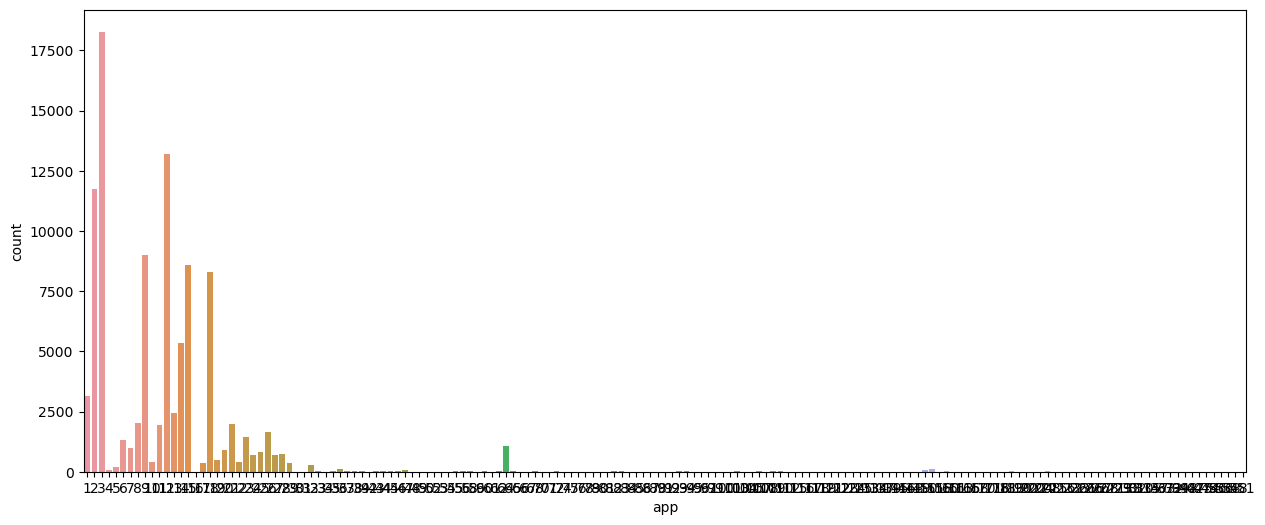

In [10]:
#distribution of 'app' 
plt.figure(figsize=(15, 6))
sns.countplot(x="app",data=df)
plt.show()

some 'apps' have a disproportionately high number of clicks (>15k), and some are very rare (3-4)

Plotting device distribution below:

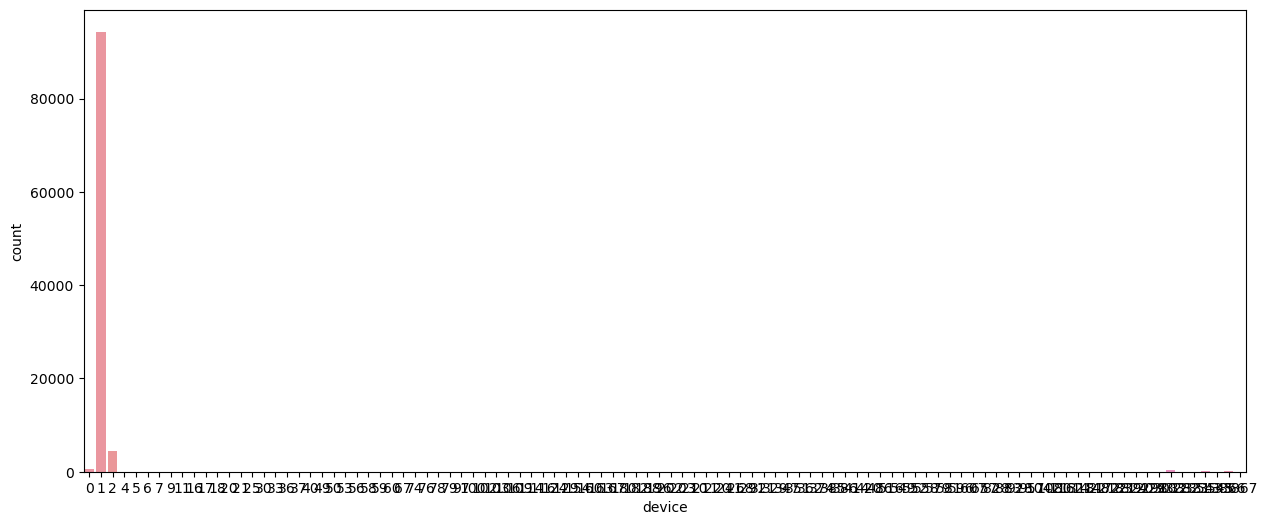

In [11]:
# distribution of 'device' 
plt.figure(figsize=(15, 6))
sns.countplot(x="device",data=df)
plt.show()

The above result is expected because a few popular devices are used heavily

Plotting channel below

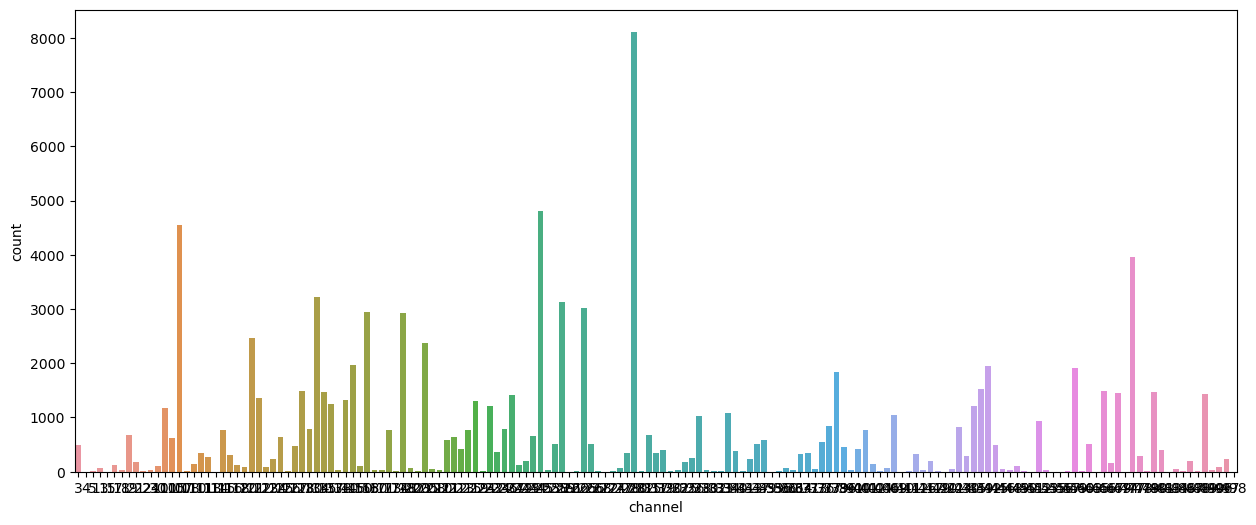

In [12]:
# distribution of 'channel' 
plt.figure(figsize=(15, 6))
sns.countplot(x="channel",data=df)
plt.show()

Various channels get clicks in comparable quantities

Distribution of 'os' now 

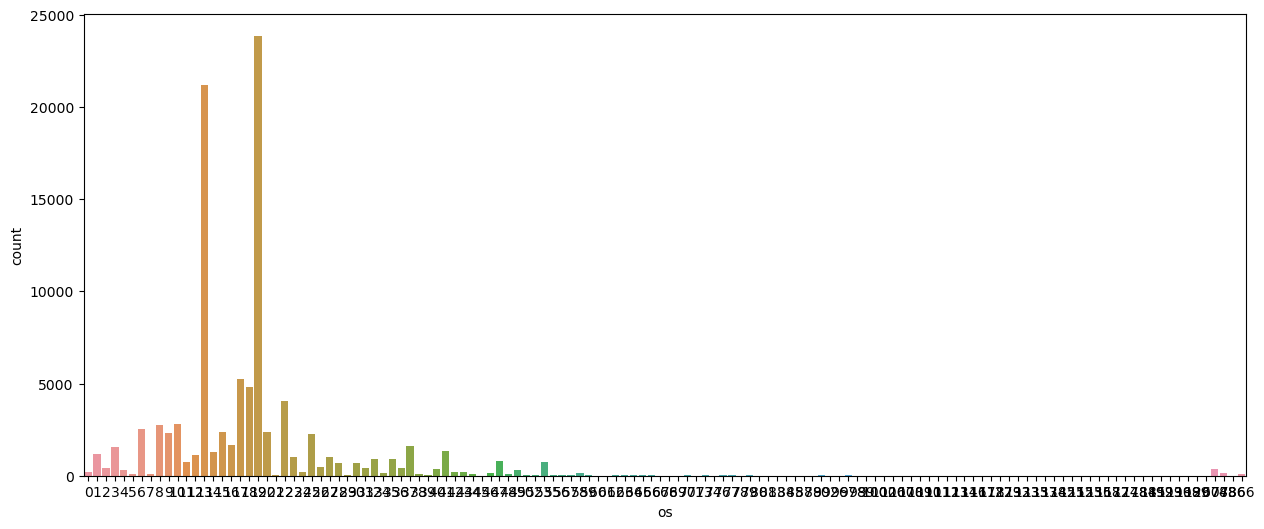

In [13]:
# distribution of 'os' 
plt.figure(figsize=(15, 6))
sns.countplot(x="os",data=df)
plt.show()

there are a couple commos OSes (android and ios?), though some are rare and can indicate suspicion 


Distribution of the target  variable 'is_attributed'.

In [14]:
# target variable distribution
100*(df["is_attributed"]).astype("object").value_counts()/len(df)

0    99.773
1     0.227
Name: is_attributed, dtype: float64

Only **about 0.2% of clicks are 'fraudulent'**, which is expected in a fraud detection problem. Such high class imbalance is probably going to be the toughest challenge of this problem.

### **`Exploring the Data - Segmented Univariate Analysis`**

How the target variable varies with the various predictors?

In [15]:
# Get average of 'is_attributed', or 'download rate' grouped with app
app_target = df.groupby("app").is_attributed.agg(["mean","count"])

# print app_target
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


This is clearly non-readable, so let's first get rid of all the apps that are very rare (say which comprise of less than 20% clicks) and plot the rest.

In [16]:
# Make a 'count' column based on app size and reset index on count
frequent_apps = df.groupby("app").size().reset_index(name="count")

# filter count greater than count above 80% quantile range
frequent_apps = frequent_apps[frequent_apps["count"]>frequent_apps["count"].quantile(0.80)] 

#inner join frequent_apps with train_sample on 'app'
frequent_apps = frequent_apps.merge(df,on="app",how="inner")

#print head of frequent_apps
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,09-11-2017 01:17,0
1,1,3135,52432,1,13,115,07-11-2017 17:22,0
2,1,3135,89242,1,27,124,07-11-2017 09:37,0
3,1,3135,123994,1,19,101,09-11-2017 14:27,0
4,1,3135,34067,1,15,134,07-11-2017 15:06,0


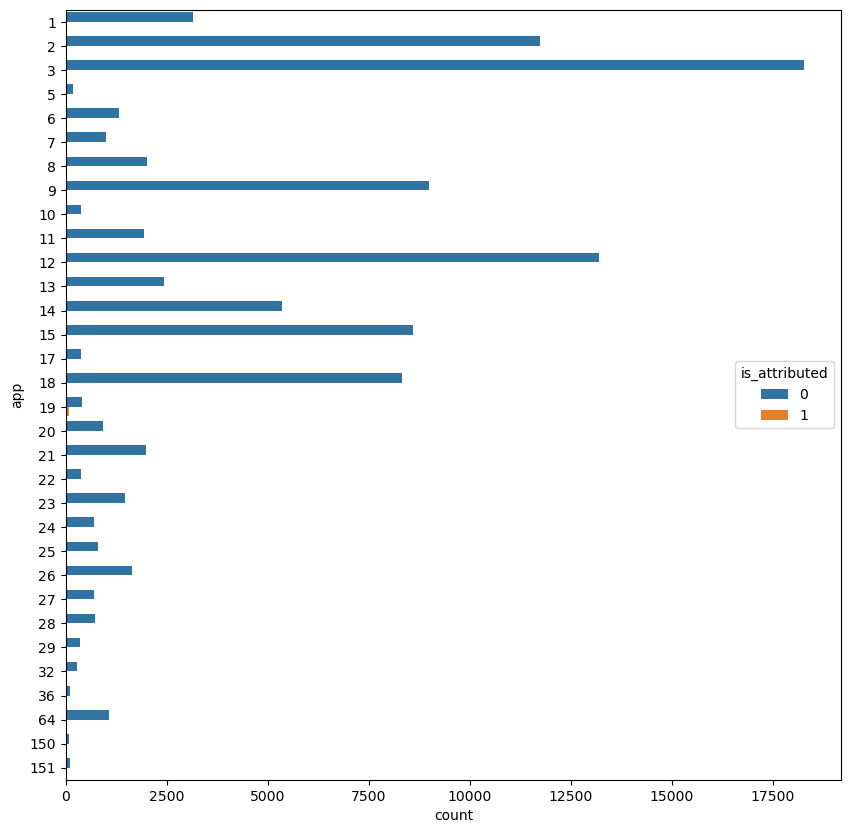

In [17]:
#plot count distribution of 'app' hued with 'is_attributed'
plt.figure(figsize=(10,10))
sns.countplot(y="app",hue="is_attributed",data=frequent_apps)
plt.show()

## **`Feature Engineering`**

Deriving some new features from the existing ones. There are a number of features one can extract from ```click_time``` itself, and by grouping combinations of IP with other features.

### Datetime Based Features


In [18]:
# Creating a function which takes in a df, adds date/time based columns to it and returns the modified df
def timeFeatures(df):
    # Creating datetime variables using the click_time column
    df['datetime'] = pd.to_datetime(df["click_time"])  # Fixed typo in to_datetime
    
    # Creating day_of_week variables extracting the day of the week from the datetime column
    df['day_of_week'] = df["datetime"].dt.dayofweek
    
    # Creating day_of_year variables extracting the day of the year from the datetime column
    df["day_of_year"] = df["datetime"].dt.dayofyear
    
    # Creating month variables extracting the month from the datetime column
    df["month"] = df["datetime"].dt.month
    
    # Creating hour variables extracting the hour from the datetime column
    df["hour"] = df["datetime"].dt.hour
    
    # Return df
    return df

In [19]:
# Creating new variables using the above function with df as train_sample
df = timeFeatures(df)

# Dropping the click_time and datetime variables from train_sample
df.drop(["click_time", "datetime"], axis=1, inplace=True)

# Print the DataFrame head
print(df.head())

       ip  app  device  os  channel  is_attributed  day_of_week  day_of_year  \
0   87540   12       1  13      497              0            1          192   
1  105560   25       1  17      259              0            1          192   
2  101424   12       1  19      212              0            1          192   
3   94584   13       1  13      477              0            1          192   
4   68413   12       1   1      178              0            0          254   

   month  hour  
0      7     9  
1      7    13  
2      7    18  
3      7     4  
4      9     9  


In [20]:
# datatypes  of all variables in train_sample
df.dtypes

ip               int64
app              int64
device           int64
os               int64
channel          int64
is_attributed    int64
day_of_week      int64
day_of_year      int64
month            int64
hour             int64
dtype: object

note that by default the new datetime variables are int64


In [21]:
# check memory/space used by training data
print("Training dataset uses {0}MB".format(df.memory_usage().sum()/1024**2))

Training dataset uses 7.6295166015625MB


Lets convert the variables back to lower dtype again


In [23]:
# get all int variables in a list
int_vars = ['ip','app','device','os','channel','is_attributed','day_of_week','day_of_year','month','hour']

# convert all above variables into uint16 type
df[int_vars] = df[int_vars].astype('uint16')

In [25]:
#print datatype of all variables in train_sample
df.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed    uint16
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

In [26]:
# space used by training data
print("Training dataset uses {0}MB".format(df.memory_usage().sum()/1024**2))

Training dataset uses 1.907470703125MB


The primitive data types prefixed with "u" are unsigned versions with the same bit sizes. Effectively, this means they cannot store negative numbers, but on the other hand they can store positive numbers twice as large as their signed counterparts. 

This is why it saves memory usage.

### **`IP Grouping Based Features`**

Creating some important features by grouping IP addresses with features such as os, channel, hour, day etc. Also, count of each IP address will also be a feature.

Note that though we are deriving new features by grouping IP addresses, using IP adress itself as a features is not a good idea. This is because (in the test data) if a new IP address is seen, the model will see a new 'category' and will not be able to make predictions (IP is a categorical variable, it has just been encoded with numbers).

`number of clicks by count of IP address
Explicitly asking pandas to re-encode the aggregated features as 'int16' to save memory`

In [27]:
# Create a column 'ip_count' using number of clicks by count of IP address 
ip_count = df.groupby("ip").size().reset_index(name="ip_count").astype("int16")

#print head of ip_count 
ip_count.head()

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


Merging this dataframe with the original training df. Similarly, we can create combinations of various features such as ip_day_hour (count of ip-day-hour combinations), ip_hour_channel, ip_hour_app, etc. 

The following function takes in a dataframe and creates these features.

In [36]:
def grouped_features(df):
    # ip_count
    ip_count = df.groupby("ip").size().reset_index(name="ip_count").astype("uint16")
    df = df.merge(ip_count, on="ip", how="left")
    
    # ip_day_hour
    ip_day_hour = df.groupby(["ip","day_of_week","hour"]).size().reset_index(name="ip_day_hour").astype("uint16")
    df = df.merge(ip_day_hour, on=["ip","day_of_week","hour"], how="left")
    
    # ip_hour_channel
    ip_hour_channel = df.groupby(["ip","hour","channel"]).size().reset_index(name="ip_hour_channel").astype("uint16")
    df = df.merge(ip_hour_channel, on=["ip","hour","channel"], how="left")

    # ip_hour_os
    ip_hour_os = df.groupby(["ip","hour","os"]).size().reset_index(name="ip_hour_os").astype("uint16")
    df = df.merge(ip_hour_os, on=["ip","hour","os"], how="left")

    # ip_hour_app
    ip_hour_app = df.groupby(["ip","hour","app"]).size().reset_index(name="ip_hour_app").astype("uint16")
    df = df.merge(ip_hour_app, on=["ip","hour","app"], how="left")

    # ip_hour_device
    ip_hour_device = df.groupby(["ip","hour","device"]).size().reset_index(name="ip_hour_device").astype("uint16")
    df = df.merge(ip_hour_device, on=["ip","hour","device"], how="left")

    return df

In [38]:
#Use above grouped_features() function with train_sample as parameter to create your new train_sample data 
df = grouped_features(df)


,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,...,ip_hour_channel_x,ip_hour_os_x,ip_hour_app_x,ip_hour_device_x,ip_count_y,ip_day_hour_y,ip_hour_channel_y,ip_hour_os_y,ip_hour_app_y,ip_hour_device_y
0,22004,12,1,13,497,0,1,192,7,9,...,1,1,1,1,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,192,7,13,...,1,1,1,8,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,192,7,18,...,1,1,1,1,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,192,7,4,...,1,1,1,1,3,1,1,1,1,1
4,2877,12,1,1,178,0,0,254,9,9,...,1,1,1,1,4,1,1,1,1,1


In [39]:
#print head of train_sample
df.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,...,ip_hour_channel_x,ip_hour_os_x,ip_hour_app_x,ip_hour_device_x,ip_count_y,ip_day_hour_y,ip_hour_channel_y,ip_hour_os_y,ip_hour_app_y,ip_hour_device_y
0,22004,12,1,13,497,0,1,192,7,9,...,1,1,1,1,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,192,7,13,...,1,1,1,8,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,192,7,18,...,1,1,1,1,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,192,7,4,...,1,1,1,1,3,1,1,1,1,1
4,2877,12,1,1,178,0,0,254,9,9,...,1,1,1,1,4,1,1,1,1,1


In [40]:
#check space usage of train_sample again
print("Training dataset uses {0}MB".format(df.memory_usage().sum()/1024**2))

Training dataset uses 4.9591064453125MB


In [41]:
# garbage collect (unused) object using gc.collect()
gc.collect()

28622

## **`Modelling`**


Building models to predict the variable ```is_attributed``` (downloaded). Try to perform on the several variants of boosting (adaboost, gradient boosting and XGBoost, LightGBM and Catboost), tune the hyperparameters in each model and choose the one which gives the best performance.


In [42]:
# create X and y train
x = df.drop("is_attributed",axis=1)
y = df[["is_attributed"]]

# split data into train and test/validation sets with test_size as 30% and random state as 101
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3,random_state=101)

#print shape of X_train, y_train, X_test and y_test
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(70000, 21)
(70000, 1)
(30000, 21)
(30000, 1)


In [43]:
# check the average download rates in train 
print(ytrain.mean())

# check the average download rates in test data, and check they should be comparable
print(ytest.mean())

is_attributed    0.002257
dtype: float64
is_attributed    0.0023
dtype: float64


### **`1.  AdaBoost`**

Reference doc: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

AdaBoost algorithm, short for Adaptive Boosting, is a Boosting technique that is used as an Ensemble Method in Machine Learning. It is called Adaptive Boosting as the weights are re-assigned to each instance, with higher weights to incorrectly classified instances. Boosting is used to reduce bias as well as the variance for supervised learning. It works on the principle where learners are grown sequentially. Except for the first, each subsequent learner is grown from previously grown learners. In simple words, weak learners are converted into strong ones. Adaboost algorithm also works on the same principle as boosting, but there is a slight difference in working. 

In [47]:
# Instantiate DecisionTreeClassifier with max_depth as 2 and random state as 1
tree = DecisionTreeClassifier(max_depth=2, random_state=1)

# adaboost with the tree as base estimator, max 600 decision trees of depth=2,
# learning_rate/shrinkage=1.5 and algorithm as "SAMME" and random_state as 1
adaboost_model_1 = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME",
    random_state=1
)

In [48]:
# fit adaboost_model_1 with training dataset
adaboost_model_1.fit(xtrain, ytrain)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=1.5, n_estimators=600, random_state=1)

In [49]:
# prediction probability on X_test
predictions = adaboost_model_1.predict_proba(xtest)

#print top 10 prediction result
predictions[:10]

array([[0.53910456, 0.46089544],
       [0.53011282, 0.46988718],
       [0.53226158, 0.46773842],
       [0.54126487, 0.45873513],
       [0.52411609, 0.47588391],
       [0.53200964, 0.46799036],
       [0.53248117, 0.46751883],
       [0.5432718 , 0.4567282 ],
       [0.52722154, 0.47277846],
       [0.52023627, 0.47976373]])

In above result the second column represents the probability of a click resulting in a download


In [50]:
# metrics: Get AUC score with parameters y_test and predicted probability result
metrics.roc_auc_score(ytest,predictions[:,1])

0.9364499701971538

### **`AdaBoost - Hyperparameter Tuning`**

Tunning the hyperparameters of the AdaBoost classifier. In this case, we have two types of hyperparameters - those of the component trees (max_depth etc.) and those of the ensemble (n_estimators, learning_rate etc.). 


We can tune both using the following technique - the keys of the form ```base_estimator_parameter_name``` belong to the trees (base estimator), and the rest belong to the ensemble.

In [52]:
# parameter grid with base_estimator__max_depth as [2,5] and n_estimators as [200, 400, 600]
param_grid = {"base_estimator__max_depth":[2,5],
              "n_estimators":[200,400,600]
}

In [55]:
# DecisionTreeClassifier as base estimator with random_state=1
tree = DecisionTreeClassifier(random_state=1)

'''adaboost with the tree as base estimator and learning rate is arbitrarily set to 0.6, 
we'll discuss learning_rate below and algorithm as "SAMME"'''

ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

#### Run grid search CV


In [56]:
# Keep cross validation fold as 3
folds = 3

# run grid search with ABC, folds, param_grid and scoring as roc_auc, return_train_score as True and verbose as 1
grid_search_ABC = GridSearchCV(ABC,
                              cv=folds,
                              param_grid=param_grid,
                              scoring="roc_auc",
                              return_train_score=True,
                              verbose=1)

In [57]:
# fit grid_search_ABC on training data
grid_search_ABC.fit(xtrain,ytrain)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(random_state=1),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [59]:
# cv results
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)

# print cv_results
print(cv_results)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      13.300376      0.605181         0.672996        0.048866   
1      23.516535      1.685403         1.112337        0.197431   
2      32.537424      0.135833         1.416323        0.114305   
3      23.041336      0.580061         0.525909        0.007357   
4      46.779289      0.774719         1.166934        0.074984   
5      70.688290      0.805150         1.681896        0.130907   

  param_base_estimator__max_depth param_n_estimators  \
0                               2                200   
1                               2                400   
2                               2                600   
3                               5                200   
4                               5                400   
5                               5                600   

                                              params  split0_test_score  \
0  {'base_estimator__max_depth': 2, 'n_estimators...          

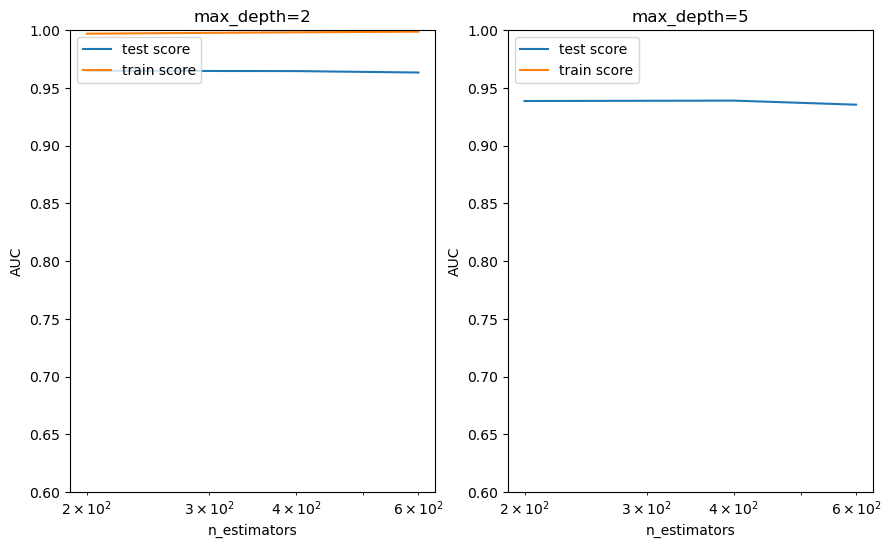

In [60]:
# plotting AUC with hyperparameter combinations

plt.figure(figsize=(16,6))
for n, depth in enumerate(param_grid['base_estimator__max_depth']):
    

    # subplot 1/n
    plt.subplot(1,3, n+1)
    depth_df = cv_results[cv_results["param_base_estimator__max_depth"]==depth]
    
    # plot depth_df["param_n_estimators"] for depth_df["mean_test_score"],depth_df["mean_train_score"] 
    plt.plot(depth_df["param_n_estimators"],depth_df["mean_test_score"])
    plt.plot(depth_df["param_n_estimators"],depth_df["mean_train_score"])
    plt.xlabel("n_estimators")
    plt.ylabel("AUC")
    plt.title("max_depth={0}".format(depth))
    plt.ylim([0.60,1])
    plt.legend(["test score","train score"], loc="upper left")
    plt.xscale("log")

The results above show that:
- The ensemble with max_depth=5 is clearly overfitting (training auc is almost 1, while the test score is much lower)
- At max_depth=2, the model performs slightly better (approx 95% AUC) with a higher test score 

Thus, going ahead with ```max_depth=2``` and ```n_estimators=400```.


In [67]:
# DecisionTreeClassifier  as base estimator with max_depth as 2 and random_state as 1
tree = DecisionTreeClassifier(max_depth=2,random_state=1)

'''adaboost with the tree as base estimator
# learning rate is arbitrarily set as 0.6, n_eastimator as 200 and rest same'''

ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    n_estimators=400,
    algorithm="SAMME",random_state=1)

# fitting ABCon training data
ABC.fit(xtrain,ytrain)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=0.6, n_estimators=400, random_state=1)

In [68]:
# predict on test data
predictions = ABC.predict_proba(xtest)

# print top 10 prediction probabilities
predictions[:10]

array([[0.58243531, 0.41756469],
       [0.56734593, 0.43265407],
       [0.60717659, 0.39282341],
       [0.58558191, 0.41441809],
       [0.55843465, 0.44156535],
       [0.58705029, 0.41294971],
       [0.58457809, 0.41542191],
       [0.59140799, 0.40859201],
       [0.57461928, 0.42538072],
       [0.56554072, 0.43445928]])

In [69]:
# Calculate roc auc score 
metrics.roc_auc_score(ytest,predictions[:,1])

0.9313408762859892

There was no significant change in the roc_auc curve. 

### **`2. Gradient Boosting Classifier`**



Reference doc: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html


Boosting is a method of converting weak learners into strong learners. In boosting, each new tree is a fit on a modified version of the original data set. 

Let's now try the gradient boosting classifier. We'll experiment with two main hyperparameters now - ```learning_rate``` (shrinkage) and ```subsample```. 

By adjusting the learning rate to less than 1, we can regularize the model. A model with higher learning_rate learns fast, but is prone to overfitting; one with a lower learning rate learns slowly, but avoids overfitting.

Also, there's a trade-off between ```learning_rate``` and ```n_estimators``` - the higher the learning rate, the lesser trees the model needs (and thus we usually tune only one of them).

Also, by subsampling (setting ```subsample``` to less than 1), we can have the individual models built on random subsamples of size ```subsample```. That way, each tree will be trained on different subsets and reduce the model's variance.

## **`Gradient Boosting Intuition`**

In [70]:
# parameter grid with learning_rate as [0.2, 0.6, 0.9] and subsample as [0.3, 0.6, 0.9]
param_grid = {
    "learning_rate":[0.2,0.6,0.9],
    "subsample":[0.3,0.6,0.9]
}

In [73]:
# Gradient boost as base estimator with max_depth as 2 and n_estimators as 200 and random_state as 1
GBC = GradientBoostingClassifier(max_depth=2,n_estimators=200,random_state=1)

##### Run grid search


In [75]:
# CV folds as 3
folds = 3

#Instantiate grid search with GBC, folds, param_grid and scoring as roc_auc, return_train_score as True and verbose as 1
grid_search_GBC = GridSearchCV(GBC,
                              cv=folds,
                              param_grid=param_grid,
                              scoring="roc_auc",
                              return_train_score=True,
                              verbose=1)

# grid_search_GBC fit on training data 
grid_search_GBC.fit(xtrain,ytrain)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_depth=2, n_estimators=200,
                                                  random_state=1),
             param_grid={'learning_rate': [0.2, 0.6, 0.9],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [76]:
# cv results
cv_results = pd.DataFrame(grid_search_GBC.cv_results_)

# print head
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,5.139570,0.504803,0.052865,0.009903,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.883115,0.919094,0.687078,0.829762,0.101957,2,0.902323,0.924267,0.621054,0.815881,0.138054
1,7.593229,0.462119,0.053483,0.018026,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.815989,0.718158,0.802269,0.778805,0.043249,3,0.826201,0.719815,0.792908,0.779641,0.044434
2,9.412218,0.303095,0.034584,0.008978,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.982359,0.904760,0.939435,0.942184,0.031739,1,0.962315,0.863953,0.940718,0.922329,0.042209
3,4.571127,0.247184,0.036435,0.007375,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.579072,0.636647,0.906190,0.707303,0.142585,4,0.541489,0.643093,0.871293,0.685292,0.137909
4,7.139841,0.135575,0.043450,0.008908,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.569097,0.731262,0.580022,0.626794,0.074005,6,0.542453,0.705398,0.609525,0.619125,0.066868


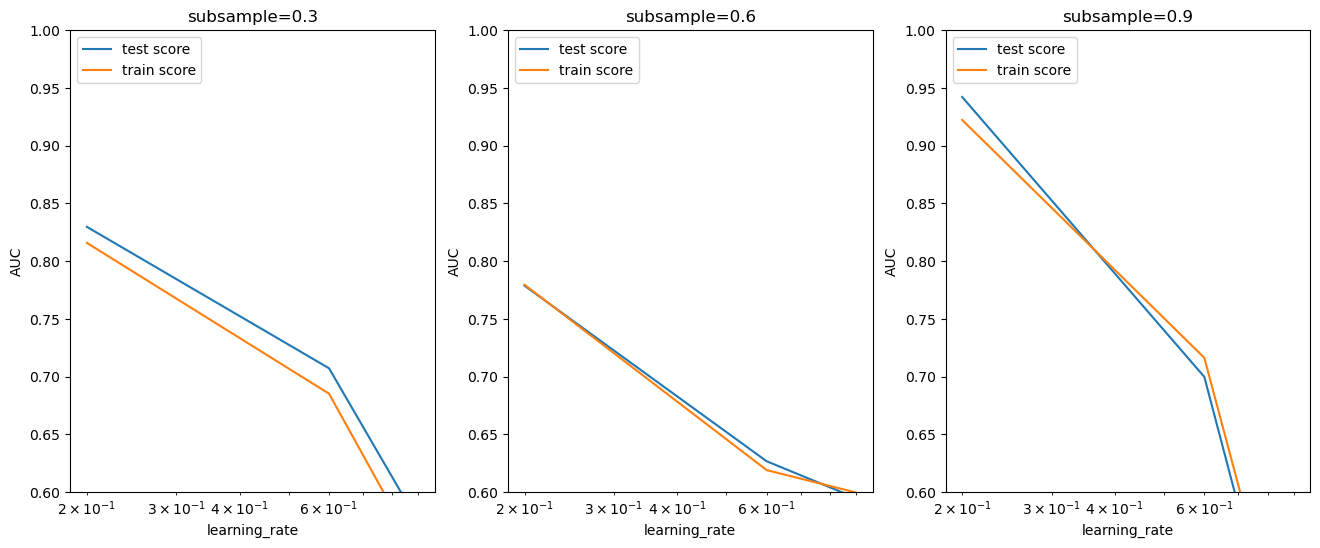

In [80]:
# plotting AUC with hyperparameter combinations, i.e., subsample
plt.figure(figsize=(16, 6))

for n, subsample in enumerate(param_grid['subsample']):
    # subplot 1/n
    plt.subplot(1, len(param_grid['subsample']), n+1)
    df = cv_results[cv_results["param_subsample"] == subsample]

    # plot df["param_learning_rate"] for df["mean_test_score"], df["mean_train_score"]
    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel("learning_rate")
    plt.ylabel("AUC")
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(["test score", "train score"], loc="upper left")
    plt.xscale("log")

plt.show()

It is clear from the plot above that the model with a lower subsample ratio performs better, while those with higher subsamples tend to overfit. 

Also, a lower learning rate results in less overfitting.

In [83]:
# fitting GBC training data
GBC.fit(xtrain,ytrain)

# predict probabilities on test data
predictions = GBC.predict_proba(xtest)

# print top 10 prediction probabilities
predictions[:10]

array([[9.99824708e-01, 1.75292181e-04],
       [9.99690904e-01, 3.09096040e-04],
       [9.99511288e-01, 4.88711933e-04],
       [9.99823970e-01, 1.76029942e-04],
       [9.99299557e-01, 7.00442578e-04],
       [9.99853051e-01, 1.46949069e-04],
       [9.99572609e-01, 4.27391263e-04],
       [9.99835995e-01, 1.64005364e-04],
       [9.99811856e-01, 1.88144133e-04],
       [9.98926818e-01, 1.07318177e-03]])

In [84]:
# Calculate roc auc score 
metrics.roc_auc_score(ytest,predictions[:,1])

0.931972522308556

So Gradient boosting also gives us 93% of roc_auc coverage

### **`3. XGBoost`**


Reference doc:https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks. However, when it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now. Please see the chart below for the evolution of tree-based algorithms over the years.

Let's finally try XGBoost. The hyperparameters are the same, some important ones being ```subsample```, ```learning_rate```, ```max_depth``` etc.


## **`XGBOOST Intuition`**

In [85]:
# Instantiate XGBClassifier with default hyperparameters and random_state=1
model = XGBClassifier(random_state=1)

# fit model on training data
model.fit(xtrain,ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

Make predictions for test data


In [86]:
# use predict_proba since we need probabilities to compute auc
y_pred = model.predict_proba(xtest)

#print top 10 y_pred result
y_pred[:10]

array([[9.9999601e-01, 3.9944102e-06],
       [9.9996400e-01, 3.5994544e-05],
       [9.9999082e-01, 9.1689208e-06],
       [9.9999237e-01, 7.6375445e-06],
       [9.9997622e-01, 2.3777986e-05],
       [9.9997914e-01, 2.0881609e-05],
       [9.9977624e-01, 2.2376684e-04],
       [9.9999833e-01, 1.6825434e-06],
       [9.9996531e-01, 3.4660159e-05],
       [9.9955845e-01, 4.4156198e-04]], dtype=float32)

In [89]:
# evaluate predictions using roc_auc score
roc = metrics.roc_auc_score(ytest,y_pred[:,1])

# print AUC
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 91.33%


The roc_auc in this case is about 0.91% with default hyperparameters. Let's try changing the hyperparameters - an exhaustive list of XGBoost hyperparameters is here: http://xgboost.readthedocs.io/en/latest/parameter.html

Let's now try tuning the hyperparameters using k-fold CV. We'll then use grid search CV to find the optimal values of hyperparameters.

In [92]:
# hyperparameter tuning with XGBoost

# creating a KFold object( 3 )
folds = 3

# specify range of hyperparameters with learning_rate as [0.2, 0.6] ans subsample as [0.3, 0.6, 0.9]
param_grid = {"learning_rate":[0.2,0.6],"subsample":[0.3,0.6,0.9]}

# specify model with max_depth as 2 and n_estimators as 200 and random_state as 1
xgb_model = XGBClassifier(max_depth=2,n_estimators=200,random_state=1)

# set up GridSearchCV() with xgb_model, param_grid, folds, return_train_score and verbose as 1
model_cv = GridSearchCV(estimator = xgb_model,
                       param_grid=param_grid,
                       scoring="roc_auc",
                       cv=folds,
                       verbose=1,
                       return_train_score=True)

In [93]:
# fit the model_cv on training data
model_cv.fit(xtrain,ytrain)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, 

In [94]:
# Get cv results as datafame
cv_results = pd.DataFrame(model_cv.cv_results_)

# print cv_results
print(cv_results)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       2.280553      0.028041         0.031551    4.371502e-04   
1       3.027376      0.256102         0.031242    4.495664e-07   
2       2.355827      0.043736         0.038551    1.033334e-02   
3       2.657927      0.229643         0.040595    1.295336e-02   
4       3.135865      0.225093         0.038395    4.512250e-04   
5       3.199750      0.233470         0.036099    8.601460e-04   

  param_learning_rate param_subsample  \
0                 0.2             0.3   
1                 0.2             0.6   
2                 0.2             0.9   
3                 0.6             0.3   
4                 0.6             0.6   
5                 0.6             0.9   

                                     params  split0_test_score  \
0  {'learning_rate': 0.2, 'subsample': 0.3}           0.986984   
1  {'learning_rate': 0.2, 'subsample': 0.6}           0.976366   
2  {'learning_rate': 0.2, 'subsample': 0.9} 

Convert parameters to int for plotting on x-axis


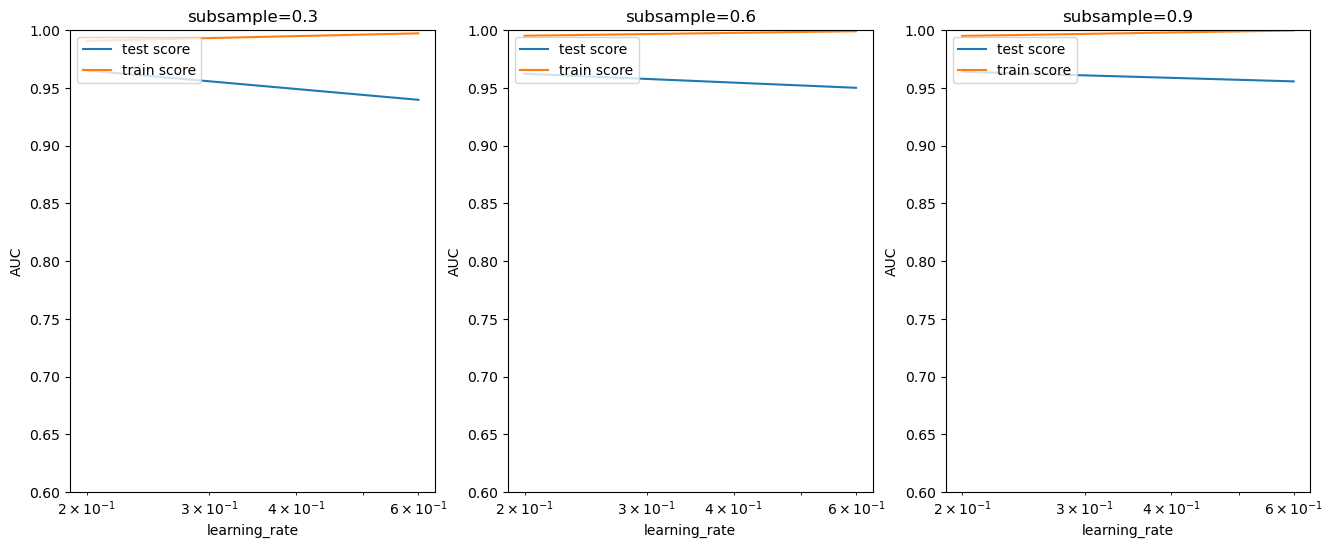

In [95]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {"learning_rate":[0.2,0.6],
             "subsample":[0.3,0.6,0.9]}

for n, subsample in enumerate(param_grid['subsample']):

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results["param_subsample"]==subsample]
    
    # plot df["param_learning_rate"] for df["mean_test_score"], df["mean_train_score"]
    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel("learning_rate")
    plt.ylabel("AUC")
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(["test score", "train score"], loc="upper left")
    plt.xscale("log")

plt.show() 

The results show that a subsample size of 0.9 and learning_rate of about 0.2 seems optimal. 
Also, XGBoost has resulted in the highest ROC AUC obtained (across various hyperparameters). 

In [98]:
# 4 chosen hyperparameters and use 'objective':'binary:logistic' which outputs probability rather than label, which we need for auc
params = {"learning_rate":0.2,
         "max_depth":2,
         "n_estimators":200,
         "subsample":0.9,
         "objective":"binary:logistic",
         "random_state":1}

#Instantiate XGBClassifier with params
XGB = XGBClassifier(params=params)

# fit model on training data
XGB.fit(xtrain,ytrain)

[00:22:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "params" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'random_state': 1,
                      'subsample': 0.9},
              predictor=None, ...)

In [99]:
# get prediction probability
y_pred = model.predict_proba(xtest)

#print to 10 prediction result
y_pred[:10]

array([[9.9999601e-01, 3.9944102e-06],
       [9.9996400e-01, 3.5994544e-05],
       [9.9999082e-01, 9.1689208e-06],
       [9.9999237e-01, 7.6375445e-06],
       [9.9997622e-01, 2.3777986e-05],
       [9.9997914e-01, 2.0881609e-05],
       [9.9977624e-01, 2.2376684e-04],
       [9.9999833e-01, 1.6825434e-06],
       [9.9996531e-01, 3.4660159e-05],
       [9.9955845e-01, 4.4156198e-04]], dtype=float32)

The first column in y_pred is the P(0), i.e. P(not fraud), and the second column is P(1/fraud).

In [100]:
# print roc_auc score
auc = sklearn.metrics.roc_auc_score(ytest,y_pred[:,1])
auc

0.9133175385512282

Even after hyerparameter tuning we got same roc_auc score. Finally, let's also look at the feature importances.

In [101]:
# print feature importance for each column in  a dictionary form
importance = dict(zip(xtrain.columns,model.feature_importances_))
importance

{'ip': 0.047461666,
 'app': 0.15999207,
 'device': 0.20826675,
 'os': 0.07708658,
 'channel': 0.14787896,
 'day_of_week': 0.047563616,
 'day_of_year': 0.05169304,
 'month': 0.0,
 'hour': 0.04659958,
 'ip_count_x': 0.07044621,
 'ip_day_hour_x': 0.043013226,
 'ip_hour_channel_x': 0.0,
 'ip_hour_os_x': 0.02566671,
 'ip_hour_app_x': 0.023731941,
 'ip_hour_device_x': 0.050599612,
 'ip_count_y': 0.0,
 'ip_day_hour_y': 0.0,
 'ip_hour_channel_y': 0.0,
 'ip_hour_os_y': 0.0,
 'ip_hour_app_y': 0.0,
 'ip_hour_device_y': 0.0}

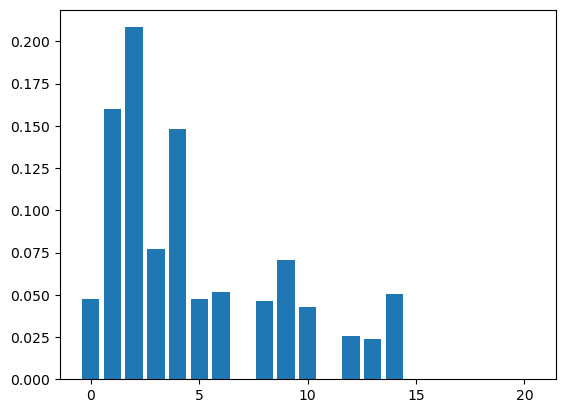

In [102]:
# plot feature importance for every column
plt.bar(range(len(model.feature_importances_)),model.feature_importances_)
plt.show()

## **`4.  LightGBM`**

Reference doc: https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’.

**Advantages of Light GBM**

1. Faster training speed and higher efficiency: Light GBM use histogram based algorithm i.e it buckets continuous feature values into discrete bins which fasten the training procedure.
2. Lower memory usage: Replaces continuous values to discrete bins which result in lower memory usage.
3. Better accuracy than any other boosting algorithm: It produces much more complex trees by following leaf wise split approach rather than a level-wise approach which is the main factor in achieving higher accuracy. However, it can sometimes lead to overfitting which can be avoided by setting the max_depth parameter.
4. Compatibility with Large Datasets: It is capable of performing equally good with large datasets with a significant reduction in training time as compared to XGBOOST.
5. Parallel learning supported.

I guess you must have got excited about the advantages of Light GBM. So lets get started with it

In [105]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 1.3/1.3 MB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [106]:
# Import LGBMClassifier from lightgbm
from lightgbm import LGBMClassifier

# Instantiate LGBMClassifier with default hyperparameters and random_state=1
lgb = LGBMClassifier(random_state=1)

# Fit the model on training data
lgb.fit(xtrain, ytrain)

[LightGBM] [Info] Number of positive: 158, number of negative: 69842
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1097
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002257 -> initscore=-6.091396
[LightGBM] [Info] Start training from score -6.091396


LGBMClassifier(random_state=1)

In [107]:
# use predict_proba since we need probabilities to compute auc
y_pred = lgb.predict_proba(xtest)

#print top 10 y_pred result
y_pred[:10]

array([[1.00000000e+00, 1.45593827e-71],
       [9.99999507e-01, 4.92675213e-07],
       [1.00000000e+00, 0.00000000e+00],
       [9.99996567e-01, 3.43287578e-06],
       [9.99998019e-01, 1.98069924e-06],
       [9.99999857e-01, 1.42861563e-07],
       [1.00000000e+00, 3.43370552e-19],
       [9.99996800e-01, 3.20026384e-06],
       [9.99999630e-01, 3.70334130e-07],
       [9.99965567e-01, 3.44330575e-05]])

In [110]:
# evaluate predictions using roc_auc score
roc = metrics.roc_auc_score(ytest,y_pred[:,1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 69.04%


Now lets tune above model. The exhaustive list of hyperparameters in LightGBM are https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

But lets run the LightGBM with previous selected hyperparamters i.e.

`'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'
         'random_state':1}`
         
Lets see if it improves

In [112]:
# Define parameters as above
# params = {'learning_rate': 0.2,
#           'max_depth': 2, 
#           'n_estimators':200,
#           'subsample':0.6,
#          'objective':'binary:logistic',
#          'random_state':1}

# Instantiate XGBClassifier with params
LGB = LGBMClassifier(learning_rate=0.2,max_depth=2,n_estimators=200,subsample=0.6,random_state=1)

# fit model on training data
LGB.fit(xtrain,ytrain)

[LightGBM] [Info] Number of positive: 158, number of negative: 69842
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1097
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002257 -> initscore=-6.091396
[LightGBM] [Info] Start training from score -6.091396


LGBMClassifier(learning_rate=0.2, max_depth=2, n_estimators=200, random_state=1,
               subsample=0.6)

In [114]:
# Use predict_proba since we need probabilities to compute AUC
y_pred_prob = lgb.predict_proba(xtest)

# Evaluate predictions using roc_auc score
roc = metrics.roc_auc_score(ytest, y_pred_prob[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 69.04%


Even after tuning we have got lower AUC score.


## **`5. CatBoost`**

CatBoost is a recently open-sourced machine learning algorithm from Yandex. It can easily integrate with deep learning frameworks like Google’s TensorFlow and Apple’s Core ML. It can work with diverse data types to help solve a wide range of problems that businesses face today. To top it up, it provides best-in-class accuracy.

It is especially powerful in two ways:

It yields state-of-the-art results without extensive data training typically required by other machine learning methods, and
Provides powerful out-of-the-box support for the more descriptive data formats that accompany many business problems.
“CatBoost” name comes from two words “Category” and “Boosting”.

As discussed, the library works well with multiple Categories of data, such as audio, text, image including historical data.

## **`CatBoost Training`**

In [115]:
!pip3 install catboost

Defaulting to user installation because normal site-packages is not writeable


In [122]:
# import CatBoostClassifier
from catboost import CatBoostClassifier

# Instantiate CatBoostClassifier with default hyperparameters and random_state=1
Cat = CatBoostClassifier(random_state=1)

# fit model on training data
Cat.fit(xtrain,ytrain)

Learning rate set to 0.063211
0:	learn: 0.5150162	total: 19.7ms	remaining: 19.6s
1:	learn: 0.3865353	total: 35.9ms	remaining: 17.9s
2:	learn: 0.2821273	total: 54.3ms	remaining: 18s
3:	learn: 0.2134119	total: 71.8ms	remaining: 17.9s
4:	learn: 0.1625690	total: 89.2ms	remaining: 17.7s
5:	learn: 0.1268583	total: 106ms	remaining: 17.6s
6:	learn: 0.0983825	total: 123ms	remaining: 17.4s
7:	learn: 0.0796084	total: 139ms	remaining: 17.3s
8:	learn: 0.0645658	total: 156ms	remaining: 17.1s
9:	learn: 0.0539091	total: 173ms	remaining: 17.1s
10:	learn: 0.0460097	total: 191ms	remaining: 17.1s
11:	learn: 0.0383052	total: 209ms	remaining: 17.2s
12:	learn: 0.0329417	total: 232ms	remaining: 17.6s
13:	learn: 0.0290397	total: 249ms	remaining: 17.5s
14:	learn: 0.0258014	total: 266ms	remaining: 17.5s
15:	learn: 0.0224344	total: 283ms	remaining: 17.4s
16:	learn: 0.0202907	total: 300ms	remaining: 17.4s
17:	learn: 0.0181333	total: 317ms	remaining: 17.3s
18:	learn: 0.0170092	total: 334ms	remaining: 17.2s
19:	lear

172:	learn: 0.0048364	total: 3.25s	remaining: 15.5s
173:	learn: 0.0048261	total: 3.27s	remaining: 15.5s
174:	learn: 0.0048235	total: 3.29s	remaining: 15.5s
175:	learn: 0.0048173	total: 3.31s	remaining: 15.5s
176:	learn: 0.0048077	total: 3.33s	remaining: 15.5s
177:	learn: 0.0047925	total: 3.35s	remaining: 15.5s
178:	learn: 0.0047812	total: 3.37s	remaining: 15.5s
179:	learn: 0.0047756	total: 3.39s	remaining: 15.4s
180:	learn: 0.0047692	total: 3.41s	remaining: 15.4s
181:	learn: 0.0047411	total: 3.43s	remaining: 15.4s
182:	learn: 0.0047305	total: 3.45s	remaining: 15.4s
183:	learn: 0.0047199	total: 3.47s	remaining: 15.4s
184:	learn: 0.0047154	total: 3.49s	remaining: 15.4s
185:	learn: 0.0047069	total: 3.51s	remaining: 15.4s
186:	learn: 0.0046933	total: 3.53s	remaining: 15.4s
187:	learn: 0.0046916	total: 3.55s	remaining: 15.3s
188:	learn: 0.0046796	total: 3.57s	remaining: 15.3s
189:	learn: 0.0046764	total: 3.59s	remaining: 15.3s
190:	learn: 0.0046674	total: 3.61s	remaining: 15.3s
191:	learn: 

337:	learn: 0.0034566	total: 7.48s	remaining: 14.7s
338:	learn: 0.0034516	total: 7.51s	remaining: 14.7s
339:	learn: 0.0034424	total: 7.54s	remaining: 14.6s
340:	learn: 0.0034346	total: 7.57s	remaining: 14.6s
341:	learn: 0.0034210	total: 7.59s	remaining: 14.6s
342:	learn: 0.0034184	total: 7.61s	remaining: 14.6s
343:	learn: 0.0034055	total: 7.64s	remaining: 14.6s
344:	learn: 0.0034001	total: 7.66s	remaining: 14.6s
345:	learn: 0.0033862	total: 7.69s	remaining: 14.5s
346:	learn: 0.0033756	total: 7.72s	remaining: 14.5s
347:	learn: 0.0033736	total: 7.75s	remaining: 14.5s
348:	learn: 0.0033696	total: 7.77s	remaining: 14.5s
349:	learn: 0.0033611	total: 7.8s	remaining: 14.5s
350:	learn: 0.0033563	total: 7.82s	remaining: 14.5s
351:	learn: 0.0033499	total: 7.84s	remaining: 14.4s
352:	learn: 0.0033425	total: 7.87s	remaining: 14.4s
353:	learn: 0.0033324	total: 7.89s	remaining: 14.4s
354:	learn: 0.0033286	total: 7.92s	remaining: 14.4s
355:	learn: 0.0033205	total: 7.94s	remaining: 14.4s
356:	learn: 0

499:	learn: 0.0026850	total: 11.4s	remaining: 11.4s
500:	learn: 0.0026744	total: 11.5s	remaining: 11.4s
501:	learn: 0.0026736	total: 11.5s	remaining: 11.4s
502:	learn: 0.0026692	total: 11.5s	remaining: 11.4s
503:	learn: 0.0026640	total: 11.5s	remaining: 11.4s
504:	learn: 0.0026606	total: 11.6s	remaining: 11.3s
505:	learn: 0.0026586	total: 11.6s	remaining: 11.3s
506:	learn: 0.0026492	total: 11.6s	remaining: 11.3s
507:	learn: 0.0026471	total: 11.6s	remaining: 11.3s
508:	learn: 0.0026397	total: 11.6s	remaining: 11.2s
509:	learn: 0.0026362	total: 11.7s	remaining: 11.2s
510:	learn: 0.0026354	total: 11.7s	remaining: 11.2s
511:	learn: 0.0026333	total: 11.7s	remaining: 11.1s
512:	learn: 0.0026314	total: 11.7s	remaining: 11.1s
513:	learn: 0.0026309	total: 11.7s	remaining: 11.1s
514:	learn: 0.0026294	total: 11.8s	remaining: 11.1s
515:	learn: 0.0026268	total: 11.8s	remaining: 11.1s
516:	learn: 0.0026230	total: 11.8s	remaining: 11s
517:	learn: 0.0026132	total: 11.8s	remaining: 11s
518:	learn: 0.00

665:	learn: 0.0020637	total: 15.1s	remaining: 7.59s
666:	learn: 0.0020624	total: 15.2s	remaining: 7.57s
667:	learn: 0.0020590	total: 15.2s	remaining: 7.54s
668:	learn: 0.0020587	total: 15.2s	remaining: 7.52s
669:	learn: 0.0020519	total: 15.2s	remaining: 7.5s
670:	learn: 0.0020509	total: 15.2s	remaining: 7.47s
671:	learn: 0.0020452	total: 15.3s	remaining: 7.45s
672:	learn: 0.0020440	total: 15.3s	remaining: 7.43s
673:	learn: 0.0020435	total: 15.3s	remaining: 7.4s
674:	learn: 0.0020388	total: 15.3s	remaining: 7.38s
675:	learn: 0.0020358	total: 15.3s	remaining: 7.36s
676:	learn: 0.0020346	total: 15.4s	remaining: 7.33s
677:	learn: 0.0020270	total: 15.4s	remaining: 7.31s
678:	learn: 0.0020260	total: 15.4s	remaining: 7.29s
679:	learn: 0.0020257	total: 15.4s	remaining: 7.26s
680:	learn: 0.0020236	total: 15.5s	remaining: 7.24s
681:	learn: 0.0020203	total: 15.5s	remaining: 7.22s
682:	learn: 0.0020186	total: 15.5s	remaining: 7.19s
683:	learn: 0.0020177	total: 15.5s	remaining: 7.17s
684:	learn: 0.

832:	learn: 0.0016763	total: 18.6s	remaining: 3.73s
833:	learn: 0.0016759	total: 18.7s	remaining: 3.71s
834:	learn: 0.0016724	total: 18.7s	remaining: 3.69s
835:	learn: 0.0016719	total: 18.7s	remaining: 3.67s
836:	learn: 0.0016711	total: 18.7s	remaining: 3.64s
837:	learn: 0.0016687	total: 18.7s	remaining: 3.62s
838:	learn: 0.0016666	total: 18.7s	remaining: 3.6s
839:	learn: 0.0016651	total: 18.8s	remaining: 3.57s
840:	learn: 0.0016616	total: 18.8s	remaining: 3.55s
841:	learn: 0.0016610	total: 18.8s	remaining: 3.53s
842:	learn: 0.0016551	total: 18.8s	remaining: 3.5s
843:	learn: 0.0016530	total: 18.8s	remaining: 3.48s
844:	learn: 0.0016513	total: 18.9s	remaining: 3.46s
845:	learn: 0.0016504	total: 18.9s	remaining: 3.44s
846:	learn: 0.0016501	total: 18.9s	remaining: 3.41s
847:	learn: 0.0016460	total: 18.9s	remaining: 3.39s
848:	learn: 0.0016418	total: 18.9s	remaining: 3.37s
849:	learn: 0.0016409	total: 18.9s	remaining: 3.34s
850:	learn: 0.0016387	total: 19s	remaining: 3.32s
851:	learn: 0.00

996:	learn: 0.0013907	total: 22.6s	remaining: 67.9ms
997:	learn: 0.0013904	total: 22.6s	remaining: 45.3ms
998:	learn: 0.0013889	total: 22.6s	remaining: 22.7ms
999:	learn: 0.0013885	total: 22.7s	remaining: 0us


Now lets tune above model. The exhaustive list of hyperparameters in LightGBM are https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

But lets run the CatBoost with previous selected hyperparamters i.e

`learning_rate=0.2,
max_depth=2,
n_estimators=200,
subsample=0.6,
random_state=1`

and lets see if it improves

In [123]:
# Instantiate CatBoostClassifier with params
Cat = CatBoostClassifier(learning_rate=0.2,max_depth=2,n_estimators=200,subsample=0.6,random_state=1)

# fit model on training data
Cat.fit(xtrain,ytrain)

0:	learn: 0.2542265	total: 18.2ms	remaining: 3.61s
1:	learn: 0.1070362	total: 34.6ms	remaining: 3.42s
2:	learn: 0.0546728	total: 47.4ms	remaining: 3.11s
3:	learn: 0.0338518	total: 58.4ms	remaining: 2.86s
4:	learn: 0.0236856	total: 70.6ms	remaining: 2.75s
5:	learn: 0.0190754	total: 84.6ms	remaining: 2.74s
6:	learn: 0.0168926	total: 96.1ms	remaining: 2.65s
7:	learn: 0.0146929	total: 108ms	remaining: 2.58s
8:	learn: 0.0135191	total: 121ms	remaining: 2.57s
9:	learn: 0.0128192	total: 134ms	remaining: 2.55s
10:	learn: 0.0126155	total: 147ms	remaining: 2.52s
11:	learn: 0.0124217	total: 158ms	remaining: 2.47s
12:	learn: 0.0119904	total: 169ms	remaining: 2.43s
13:	learn: 0.0118855	total: 183ms	remaining: 2.44s
14:	learn: 0.0118515	total: 195ms	remaining: 2.41s
15:	learn: 0.0116326	total: 208ms	remaining: 2.39s
16:	learn: 0.0114855	total: 222ms	remaining: 2.39s
17:	learn: 0.0113649	total: 240ms	remaining: 2.42s
18:	learn: 0.0111793	total: 254ms	remaining: 2.42s
19:	learn: 0.0111591	total: 267ms	

167:	learn: 0.0063958	total: 2.81s	remaining: 536ms
168:	learn: 0.0063870	total: 2.84s	remaining: 521ms
169:	learn: 0.0063820	total: 2.87s	remaining: 506ms
170:	learn: 0.0063693	total: 2.89s	remaining: 490ms
171:	learn: 0.0063598	total: 2.91s	remaining: 474ms
172:	learn: 0.0063584	total: 2.93s	remaining: 457ms
173:	learn: 0.0063376	total: 2.95s	remaining: 441ms
174:	learn: 0.0063347	total: 2.97s	remaining: 425ms
175:	learn: 0.0063316	total: 2.99s	remaining: 408ms
176:	learn: 0.0063257	total: 3.02s	remaining: 392ms
177:	learn: 0.0063240	total: 3.04s	remaining: 375ms
178:	learn: 0.0063190	total: 3.06s	remaining: 359ms
179:	learn: 0.0063170	total: 3.08s	remaining: 343ms
180:	learn: 0.0063025	total: 3.11s	remaining: 326ms
181:	learn: 0.0062958	total: 3.13s	remaining: 309ms
182:	learn: 0.0062909	total: 3.15s	remaining: 293ms
183:	learn: 0.0062670	total: 3.17s	remaining: 276ms
184:	learn: 0.0062647	total: 3.2s	remaining: 260ms
185:	learn: 0.0062391	total: 3.22s	remaining: 242ms
186:	learn: 0

In [124]:
# Use predict_proba since we need probabilities to compute AUC
y_pred_prob = Cat.predict_proba(xtest)

# Evaluate predictions using roc_auc score
roc = metrics.roc_auc_score(ytest, y_pred_prob[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 93.48%


CatBoost gives slightly better result than all other models which we tried till now.